<a href="https://colab.research.google.com/github/kotOcelot/Milky_Way_generator/blob/main/sdss_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Импорты

In [ ]:
from astropy.io import fits
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, random_split
import torch
from PIL import Image
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
from torch import nn
import torch.optim as optim
from scipy.optimize import curve_fit
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from collections import OrderedDict
import random
import torchvision
from torchvision import transforms

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


###Картинки

In [ ]:
from collections import defaultdict
from IPython.display import clear_output


class ProgressPlotter:

    """
    Groups contain a list of variables to output, like ["loss", "accuracy"]
    If group is None all variables will be plotted

    Title is experiment_id like "Relu_Adam_lr003"
    All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="best")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [ ]:
def plot(output, target, maps, labels = ['Output', 'Target', 'Input']):
  for k in range(len(output)):
    if (len(output) != 1):
      pic_rec = output[k]
      pic = target[k]
      map = maps[k]
    else:
      pic_rec = output
      pic = target
      map = maps
    rband_rec = torch.squeeze(pic_rec, 0)
    rband_orig = torch.squeeze(pic, 0)
    map_orig = torch.squeeze(map, 0)
    fig, ax = plt.subplot_mosaic([
        labels
    ], figsize=(14, 5))
    ax[labels[0]].imshow(rband_rec.cpu().detach().numpy())
    ax[labels[1]].imshow(rband_orig.cpu().detach().numpy())
    ax[labels[2]].imshow(torch.squeeze(map_orig).cpu().detach().numpy())
    ax[labels[0]].set_title(labels[0])
    ax[labels[1]].set_title(labels[1])
    ax[labels[2]].set_title(labels[2])
    plt.show()


In [ ]:
def plot_dataset(pics, maps, labels, num = 10):
  for k in range(num):
      pic = pics[k]
      label = labels[k][:6]
      rband_orig = torch.squeeze(pic, 0)
      map_orig = torch.squeeze(map, 0)
      fig, ax = plt.subplot_mosaic([
          ['ha', 'stellar']
      ], figsize=(14, 5))
      ax['ha'].imshow(rband_orig.cpu().detach().numpy())
      ax['stellar'].imshow(torch.squeeze(map_orig).cpu().detach().numpy())
      ax['ha'].set_title(label)
      ax['stellar'].set_title(label)
      plt.show()


###Загрузка данных

In [ ]:
#Файлы тут https://drive.google.com/drive/folders/1Nd1rOCphCpagBCqI8oLnNRQJpVXbjv0H?usp=share_link
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
list_files = []
with open('/content/drive/MyDrive/SDSS Manga data/list.dat') as f:
  for line in f:
      list_files.append(line.replace('%', '')[:-1])
print(len(list_files))
list_files = np.array(list_files)

10219


In [ ]:
rgb_x = []
rgb_y = []
list_corr = []
with open('/content/drive/MyDrive/SDSS Manga data/rgb_orig/rgb_list_2.dat') as f:
     for line in f:
       if line[0] == '%':
         name = line[:14].replace('%', '')
         if (int(line[18:22])>=120) and (int(line[15:18])>=120) and (np.sum(np.isin(list_files, name)) == 1):
           list_corr.append(name)
           rgb_y.append(int(line[15:18]))
           rgb_x.append(int(line[18:22]))
print(np.mean(rgb_y), np.mean(rgb_x))
print(len(list_corr))

In [ ]:
# plt.hist(rgb_y)

In [ ]:
# ha_y = []
# ha_x = []
# with open('/content/drive/MyDrive/data/ha_list.dat') as f:
#      for line in f:
#       if line[0] == '%':
#           ha_y.append(int(line[15:18]))
#           ha_x.append(int(line[18:22]))
# print(np.mean(ha_y), np.mean(ha_x))

In [ ]:
# d_y = []
# d_x = []
# with open('/content/drive/MyDrive/data/star_disp_list.dat') as f:
#      for line in f:
#       if line[0] == '%':
#           d_y.append(int(line[15:18]))
#           d_x.append(int(line[18:22]))
# print(np.mean(d_y), np.mean(d_x))

In [ ]:
# vel_y = []
# vel_x = []
# with open('/content/drive/MyDrive/data/star_vel_list.dat') as f:
#      for line in f:
#       if line[0] == '%':
#           vel_y.append(int(line[15:18]))
#           vel_x.append(int(line[18:22]))
# print(np.mean(vel_y), np.mean(vel_x))

In [ ]:
list_files_test = list_corr[:1000]

In [ ]:
rgbs = []
for name_f in list_files_test:
  name = '{}_rgb.npy'.format(name_f)
  rgb = torch.permute(torch.tensor(np.load('/content/drive/MyDrive/SDSS Manga data/rgb_orig/{}'.format(name))).type(torch.FloatTensor), (2,0,1))
  rgbs.append(rgb)


###Датасет

In [ ]:
class DS_pics(Dataset):
    def __init__(self, images, labels, transform = None):
        super().__init__()
        self.images = images
        self.labels = labels
        #self.v_fields = v_fields
        self.transform = transform

    def __getitem__(self, indx):
        image = self.images[indx]
        label = self.labels[indx]
        #vel_field = self.v_fields[indx]

        if self.transform:
            image = self.transform(image)
            #vel_field = self.transform(vel_field)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
rgb_test = rgbs[:2]
rgb_res = rgbs[2:]
list_test = list_files_test[:2]
list_res = list_files_test[2:]

In [ ]:
transform = transforms.Compose([ transforms.Resize(size = (241, 241))],)

galaxies = DS_pics(rgb_res, list_res, transform=transform)
gal_test = DS_pics(rgb_test, list_test, transform=transform)

In [ ]:
gal_train, gal_val  = random_split(galaxies, [800, 198])

In [ ]:
train_loader = torch.utils.data.DataLoader(gal_train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(gal_val, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(gal_test, batch_size=2, shuffle=False)

###АЕ картинка - картинка

In [ ]:
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            #nn.AdaptiveAvgPool2d((225, 225)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        #print(decoded.shape)
        return decoded

In [ ]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            #nn.AdaptiveAvgPool2d((225, 225)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        #print(decoded.shape)
        return decoded

In [ ]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            #nn.AdaptiveAvgPool2d((225, 225)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

###Обучение

In [ ]:
def train(model, criterion, optimizer, num_ep, scheduler=None):
    progress = {}
    pp = ProgressPlotter(title="baseline", groups=["loss_train", "loss_val"])
    min_loss_val = 10000
    min_loss_train = 10000
    for epoch in range(num_ep):
          ep_loss_train = 0
          model.train()
          for (pic, label) in train_loader:
              optimizer.zero_grad()
              output, encoded = model(pic.to(device))
              for k in range (len(pic)):
                name_f = label[k]
                name = '{}_vector'.format(name_f)
                np.save('/content/drive/MyDrive/SDSS Manga data/vectors/{}'.format(name), torch.squeeze(encoded[k], 0).detach().cpu())
              loss = criterion(output, pic.to(device))
              loss.backward()
              optimizer.step()
              train_loss = loss.item()
              ep_loss_train += train_loss

          ep_loss_val = 0
          model.eval()
          for (pic, label) in val_loader:
              with torch.no_grad():
                  output, encoded = model(pic.to(device))
                  for k in range (len(pic)):
                    name_f = label[k]
                    name = '{}_vector'.format(name_f)
                    np.save('/content/drive/MyDrive/SDSS Manga data/vectors/{}'.format(name), torch.squeeze(encoded[k], 0).detach().cpu())
                  loss = criterion(output, pic.to(device))
                  val_loss = loss.item()
                  ep_loss_val += loss.item()
                  if scheduler:
                      scheduler.step(val_loss)
          pp.add_scalar(group = "loss_train", value = ep_loss_train/(len(train_loader)), tag = "loss_train")
          pp.add_scalar(group = "loss_val", value = ep_loss_val/(len(val_loader)), tag = "loss_val")
          pp.display()
          if val_loss < min_loss_val:
              torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train loss': train_loss,
              'val loss': val_loss,
              }, '/content/drive/MyDrive/SDSS Manga data/models/rgb_to_rgb_best_val.pth')
              min_loss_val = val_loss
          if train_loss < min_loss_train:
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train loss': train_loss,
                }, '/content/drive/MyDrive/SDSS Manga data/models/rgb_to_rgb_best_train.pth')
                min_loss_train = train_loss
          # torch.save({
          #   'epoch': epoch,
          #   'model_state_dict': model.state_dict(),
          #   'optimizer_state_dict': optimizer.state_dict(),
          #   'train loss': train_loss,
          #   'val loss': val_loss,
          #   }, '/content/drive/MyDrive/SDSS Manga data/models/rgb_to_rgb_epoch_{:3d}.pth'.format(epoch))

In [ ]:
set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder3().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.01)

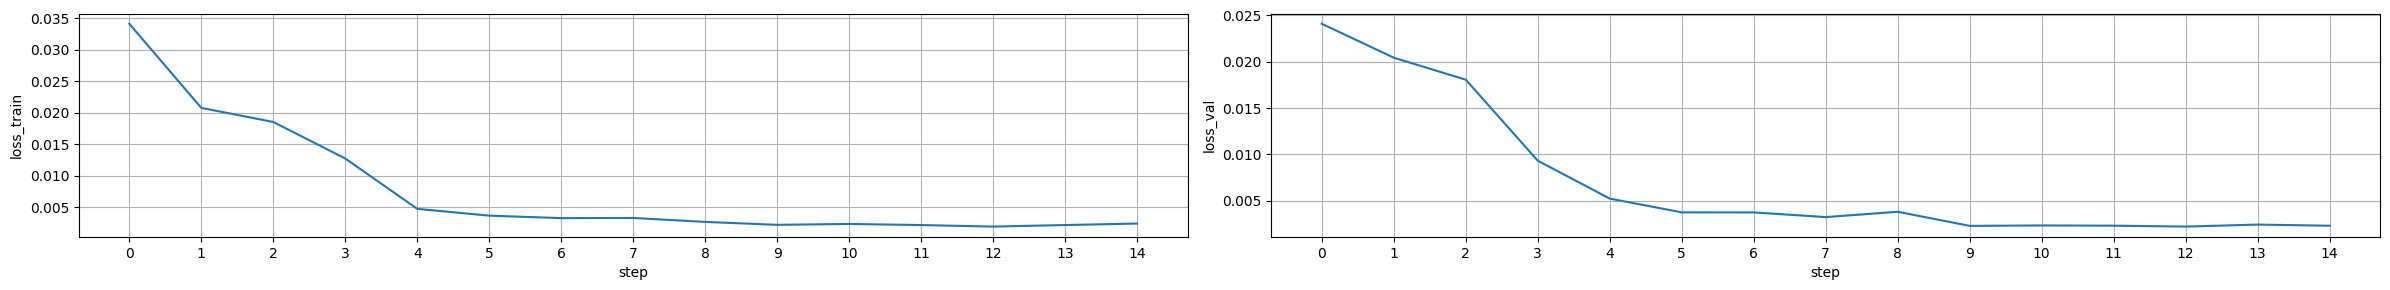

In [ ]:
pr = train(model, criterion, optimizer, 15, scheduler)

0
1


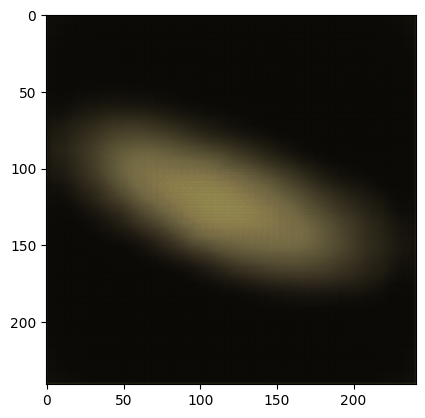

In [ ]:
model.eval()
for pic, label in test_loader:
  pic_rec, encoded = model(pic.to(device))
  for k in range (len(pic)):
    name_f = label[k]
    name = '{}_vector'.format(name_f)
    np.save('/content/drive/MyDrive/SDSS Manga data/vectors/{}'.format(name), torch.squeeze(encoded, 0).detach().cpu())
plt.imshow(torch.permute(pic_rec[0].detach().cpu(), (1,2,0)))

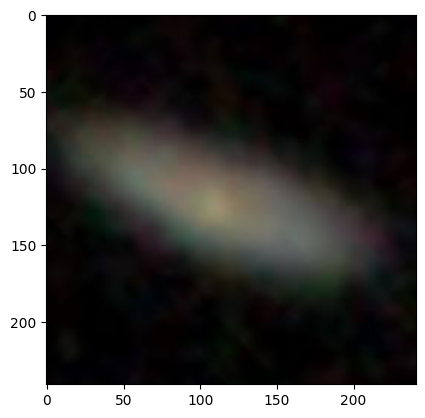

In [ ]:
plt.imshow(torch.permute(pic[0].detach().cpu(), (1,2,0)))

###Новый энкодер

In [ ]:
class New_encoder(nn.Module):
    def __init__(self):
        super(New_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((12, 12)))

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded



In [ ]:
new_encoder = New_encoder().to(device)
model.encoder = new_encoder.encoder
for param in model.decoder.parameters():
    param.requires_grad = False
for i, param in enumerate(model.parameters()):
      print(i, param.size(), param.requires_grad)

0 torch.Size([64, 1, 3, 3]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64]) True
4 torch.Size([128, 64, 3, 3]) True
5 torch.Size([128]) True
6 torch.Size([128]) True
7 torch.Size([128]) True
8 torch.Size([256, 128, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([256]) True
11 torch.Size([256]) True
12 torch.Size([512, 256, 3, 3]) True
13 torch.Size([512]) True
14 torch.Size([512]) True
15 torch.Size([512]) True
16 torch.Size([512, 256, 3, 3]) False
17 torch.Size([256]) False
18 torch.Size([256]) False
19 torch.Size([256]) False
20 torch.Size([256, 256, 3, 3]) False
21 torch.Size([256]) False
22 torch.Size([256]) False
23 torch.Size([256]) False
24 torch.Size([256, 128, 3, 3]) False
25 torch.Size([128]) False
26 torch.Size([128]) False
27 torch.Size([128]) False
28 torch.Size([128, 128, 3, 3]) False
29 torch.Size([128]) False
30 torch.Size([128]) False
31 torch.Size([128]) False
32 torch.Size([128, 64, 3, 3]) False
33 torch.Size([64]) False
34 torch.Size([64]

###Загрузка векторов

In [ ]:
list0 = list_files_test

In [ ]:
disp = []
vel = []
vectors = []
list_names = []
for name_f in list0:
  name = '{}_star_disp.pt'.format(name_f)
  std = torch.load('/content/drive/MyDrive/SDSS Manga data/st_disp/{}'.format(name)).type(torch.FloatTensor)
  disp.append(std)
  name = '{}_star_vel.pt'.format(name_f)
  stvel = torch.load('/content/drive/MyDrive/SDSS Manga data/st_vel/{}'.format(name)).type(torch.FloatTensor)
  vel.append(stvel)
  name = '{}_vector.npy'.format(name_f)
  vec = torch.tensor(np.load('/content/drive/MyDrive/SDSS Manga data/vectors/{}'.format(name))).type(torch.FloatTensor)
  vectors.append(vec)

###Считывание параметров фита плоскостью)))

In [ ]:
names = []
a = []
b = []
c = []
with open('/content/drive/MyDrive/SDSS Manga data/st_vel/star_vel_list.dat') as f:
     for line in f:
      if line[0] == '%':
          names.append(line[:14].replace('%', ''))
          l = 0
          ln = line[15:-1].split(' ')
          for f in range(len(ln)):
            if ln[f]!='':
              l += 1
              if l == 3:
                a.append(ln[f])
              if l == 4:
                b.append(ln[f])
              if l == 5:
                c.append(ln[f])
list_a = []
list_b = []
list_c = []
for name in list0:
  ind = np.where(np.array(names) == name)[0][0]
  list_a.append(float(a[ind]))
  list_b.append(float(b[ind]))
  list_c.append(float(c[ind]))

###Датасет

In [ ]:
class FindPolar(object):

    def __init__(self):
        super().__init__()

    def __call__(self, map):
        ny, nx = map.size()
        x = np.arange(nx)
        y = np.arange(ny)
        xv, yv = np.meshgrid(x, y)
        yv = np.flip(yv, 0)
        if (nx%2 == 1):
          x_c = nx//2 + 1
        else:
          x_c = nx//2
        if (ny%2 == 1):
          y_c = ny//2 + 1
        else:
          y_c = ny//2
        xv = xv + 1 - x_c
        yv = yv + 1 - y_c
        r = np.sqrt(xv**2 + yv**2)
        phi = np.arctan2(yv,xv)
        m2 = map.flatten()
        mask = torch.isnan(m2)
        m2 = m2[~mask]
        r2 = r.flatten()
        r2 = r2[~mask]
        phi2 = phi.flatten()
        phi2 = phi2[~mask]
        vrphi = torch.tensor(np.vstack((m2, r2, phi2)).T).type(torch.FloatTensor)

        return vrphi

In [ ]:
class NormalizeLog(object):

    def __init__(self):
        super().__init__()

    def __call__(self, tensor, min):
        tensor = torch.log10(tensor + abs(min) + 1)

        return tensor

In [ ]:
class FindResVel(object):

    def __init__(self):
        super().__init__()

    def surface(self):
      x = self.xy[:,0]
      y = self.xy[:,1]
      v = (self.a)*x + (self.b)*y + self.c
      return v

    def res_vel(self):
      ny, nx = self.tensor.size()
      x = np.arange(nx)
      y = np.arange(ny)
      xv, yv = np.meshgrid(x, y)
      t2 = self.tensor.flatten()
      xv2 = xv.flatten()
      yv2 = yv.flatten()
      self.xy = np.vstack((xv2, yv2)).T
      surf = torch.FloatTensor(self.surface())
      tensor = self.tensor - surf.view(ny, nx)
      return tensor

    def __call__(self, tensor, coefs):
        self.tensor = tensor
        self.a = coefs[0]
        self.b = coefs[1]
        self.c = coefs[2]
        tensor = self.res_vel()

        return tensor

In [ ]:
class DS_vectors(Dataset):
    def __init__(self, vels, disps, vectors, coefs, norm = NormalizeLog(), polar = FindPolar(), res = FindResVel()):
        super().__init__()
        self.vels = vels
        self.disps = disps
        self.a = coefs[0]
        self.b = coefs[1]
        self.c = coefs[2]
        self.vectors = vectors
        self.polar = polar
        self.norm = norm
        self.res = res


    def __getitem__(self, indx):
        vel = self.vels[indx]
        disp = self.disps[indx]
        a0 = self.a[indx]
        b0 = self.b[indx]
        c0 = self.c[indx]
        vector = self.vectors[indx]
        min_vel = np.nanmin(vel)
        min_disp = np.nanmin(disp)
        disp = self.norm(disp, min_disp)
        disp = self.polar(disp)
        vel = self.res(vel, [a0,b0,c0])
        vel = self.norm(vel, min_vel)
        vel = self.polar(vel)
        map = torch.unsqueeze(torch.concatenate((disp, vel),0), 0)
        return map, vector

    def __len__(self):
        return len(self.vels)

In [ ]:
vec_test = vectors[:2]
vec_res = vectors[2:]
d_test = disp[:2]
d_res = disp[2:]
v_test = vel[:2]
v_res = vel[2:]
list_a_test = list_a[:2]
list_a_res = list_a[2:]
list_b_test = list_b[:2]
list_b_res = list_b[2:]
list_c_test = list_c[:2]
list_c_res = list_c[2:]
list_names_test = list0[:2]

In [ ]:
galaxies_2 = DS_vectors(v_res, d_res, vec_res, [list_a_res, list_b_res, list_c_res])
gal_test_2 = DS_vectors(v_test, d_test, vec_test, [list_a_test, list_b_test, list_c_test])

In [ ]:
gal_train_2, gal_val_2  = random_split(galaxies_2, [800, 198])

In [ ]:
train_loader_2 = torch.utils.data.DataLoader(gal_train_2, batch_size=1, shuffle=True)
val_loader_2 = torch.utils.data.DataLoader(gal_val_2, batch_size=1, shuffle=False)
test_loader_2 = torch.utils.data.DataLoader(gal_test_2, batch_size=1, shuffle=False)

###Обучение

In [ ]:
def train_maps(model, criterion, optimizer, num_ep, scheduler=None):
    progress = {}
    pp = ProgressPlotter(title="baseline", groups=["loss_train", "loss_val"])
    min_loss_val = 10000
    min_loss_train = 10000
    for epoch in range(num_ep):
          ep_loss_train = 0
          model.train()
          for (map, vec) in train_loader_2:
              optimizer.zero_grad()
              output, encoded = model(map.to(device))
              loss = criterion(encoded, vec.to(device))
              loss.backward()
              optimizer.step()
              train_loss = loss.item()
              ep_loss_train += train_loss

          ep_loss_val = 0
          model.eval()
          for (map, vec) in val_loader_2:
              with torch.no_grad():
                  output, encoded = model(map.to(device))
                  loss = criterion(encoded, vec.to(device))
                  val_loss = loss.item()
                  ep_loss_val += loss.item()
                  if scheduler:
                      scheduler.step(val_loss)
          pp.add_scalar(group = "loss_train", value = ep_loss_train/(len(train_loader)), tag = "loss_train")
          pp.add_scalar(group = "loss_val", value = ep_loss_val/(len(val_loader)), tag = "loss_val")
          pp.display()
          if val_loss < min_loss_val:
              torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train loss': train_loss,
              'val loss': val_loss,
              }, '/content/drive/MyDrive/SDSS Manga data/models/vec_to_rgb_best_val.pth')
              min_loss_val = val_loss
          if train_loss < min_loss_train:
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train loss': train_loss,
                }, '/content/drive/MyDrive/SDSS Manga data/models/vec_to_rgb_best_train.pth')
                min_loss_train = train_loss
          # torch.save({
          #   'epoch': epoch,
          #   'model_state_dict': model.state_dict(),
          #   'optimizer_state_dict': optimizer.state_dict(),
          #   'train loss': train_loss,
          #   'val loss': val_loss,
          #   }, '/content/drive/MyDrive/SDSS Manga data/models/vec_to_rgb_epoch_{:3d}.pth'.format(epoch))

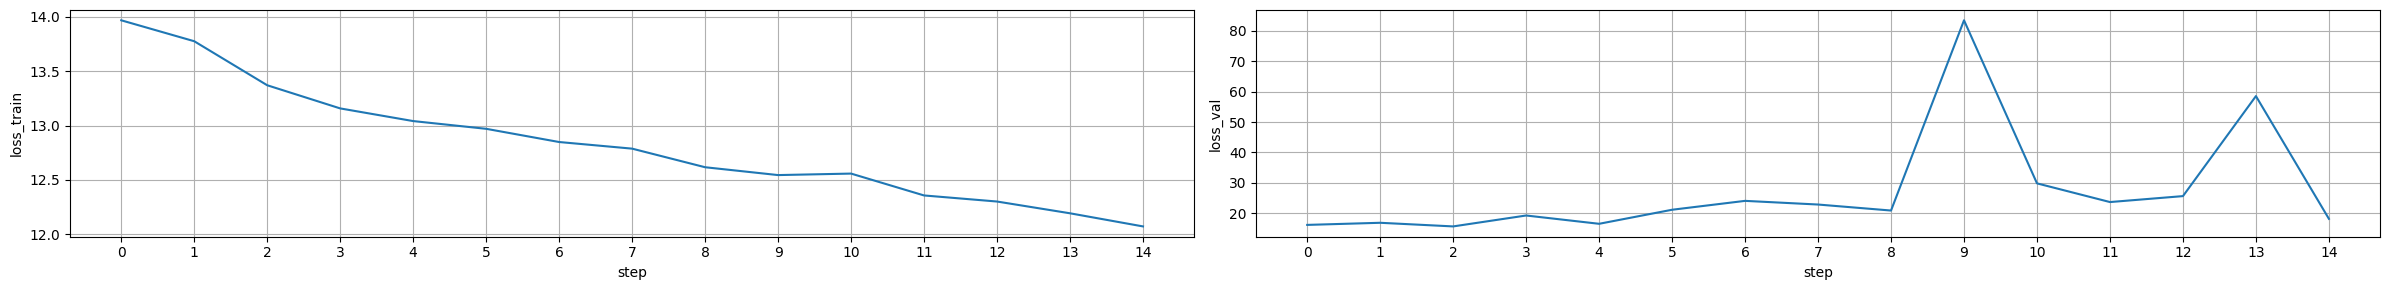

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [6], gamma = 0.01)
pr = train_maps(model, criterion, optimizer, 15, scheduler)

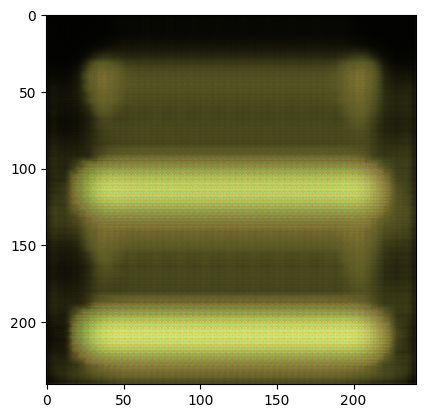

In [ ]:
model.eval()
for map, vector in test_loader_2:
  pic_rec, encoded = model(map.to(device))
plt.imshow(torch.permute(pic_rec[0].detach().cpu(), (1,2,0)))

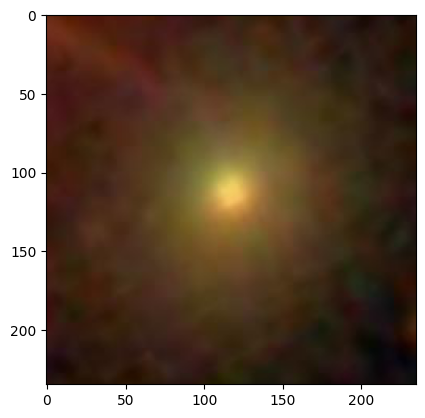

In [ ]:
name = list_names_test[-1]
name = '{}_rgb.npy'.format(name_f)
rgb = torch.tensor(np.load('/content/drive/MyDrive/SDSS Manga data/rgb_orig/{}'.format(name))).type(torch.FloatTensor)
plt.imshow(rgb)


In [ ]:
for param in model.decoder.parameters():
    param.requires_grad = True
for i, param in enumerate(model.parameters()):
      print(i, param.size(), param.requires_grad)

0 torch.Size([64, 1, 3, 3]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64]) True
4 torch.Size([128, 64, 3, 3]) True
5 torch.Size([128]) True
6 torch.Size([128]) True
7 torch.Size([128]) True
8 torch.Size([256, 128, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([256]) True
11 torch.Size([256]) True
12 torch.Size([512, 256, 3, 3]) True
13 torch.Size([512]) True
14 torch.Size([512]) True
15 torch.Size([512]) True
16 torch.Size([512, 256, 3, 3]) True
17 torch.Size([256]) True
18 torch.Size([256]) True
19 torch.Size([256]) True
20 torch.Size([256, 256, 3, 3]) True
21 torch.Size([256]) True
22 torch.Size([256]) True
23 torch.Size([256]) True
24 torch.Size([256, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128]) True
28 torch.Size([128, 128, 3, 3]) True
29 torch.Size([128]) True
30 torch.Size([128]) True
31 torch.Size([128]) True
32 torch.Size([128, 64, 3, 3]) True
33 torch.Size([64]) True
34 torch.Size([64]) True
35 torch.Si

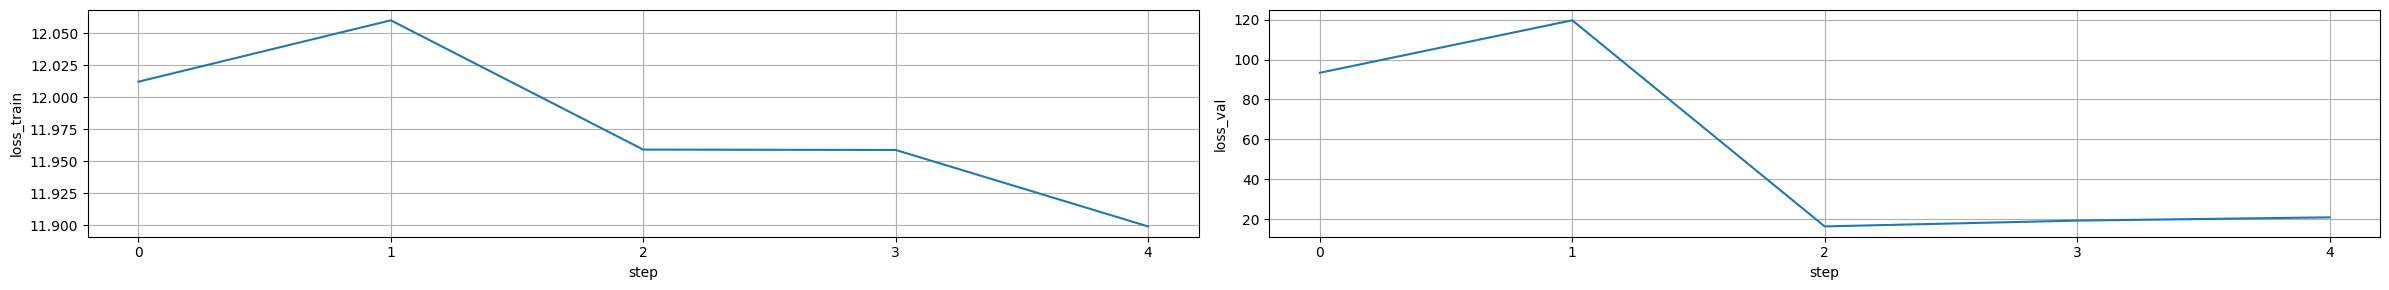

In [ ]:
pr = train_maps(model, criterion, optimizer, 5, scheduler)

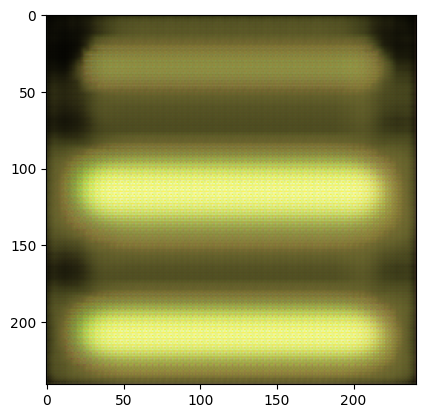

In [ ]:
model.eval()
for map, vector in test_loader_2:
  pic_rec, encoded = model(map.to(device))
plt.imshow(torch.permute(pic_rec[0].detach().cpu(), (1,2,0)))

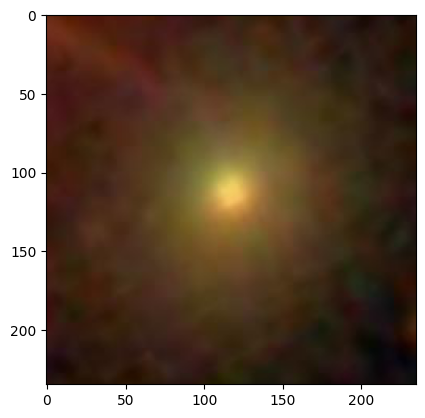

In [ ]:
name = list_names_test[-1]
name = '{}_rgb.npy'.format(name_f)
rgb = torch.tensor(np.load('/content/drive/MyDrive/SDSS Manga data/rgb_orig/{}'.format(name))).type(torch.FloatTensor)
plt.imshow(rgb)
